In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic2"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import load_excel, load_odin_as_ml_dataset, plot_confusion_matrix, make_ml_dataset, run_binary_regression, transport_modes, trip_motives, province_codes

Changed to c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation


In [2]:
# Here just in case
year = 2022
odin_excel_path = os.path.join(os.getcwd(), "data", "OdiN 2019-2023", f"OdiN {year}", f"ODiN{year}_Databestand.csv")
df = load_excel(odin_excel_path)
df = df[df["Verpl"] == 1]

Loaded file from CSV


In [3]:
print(transport_modes)

{1: 'Car - driver', 2: 'Car - passenger', 3: 'Train', 4: 'Bus/tram/metro', 5: 'Bicycle', 6: 'On foot', 7: 'Other'}


In [4]:
print(trip_motives)

{1: 'Work', 2: 'Business', 3: 'Services/personal care', 4: 'Shopping', 5: 'Education', 6: 'Visit/stay overnight', 7: 'Other social/recreational', 8: 'Touring/walking', 9: 'Other motive'}


In [5]:
print(province_codes)

{0: 'No departure point in the Netherlands', 1: 'Groningen', 2: 'Friesland', 3: 'Drenthe', 4: 'Overijssel', 5: 'Flevoland', 6: 'Gelderland', 7: 'Utrecht', 8: 'North Holland', 9: 'South Holland', 10: 'Zeeland', 11: 'North Brabant', 12: 'Limburg', 99: 'Unknown'}


In [6]:
df.columns

Index(['OP', 'OPID', 'Steekproef', 'Mode', 'HHPers', 'HHSam', 'HHPlOP',
       'HHLft1', 'HHLft2', 'HHLft3',
       ...
       'RReisduur', 'RReisduurBL', 'RVertStat', 'RAankStat', 'RTSamen',
       'RCorrSnelh', 'RVliegVer', 'FactorH', 'FactorP', 'FactorV'],
      dtype='object', length=247)

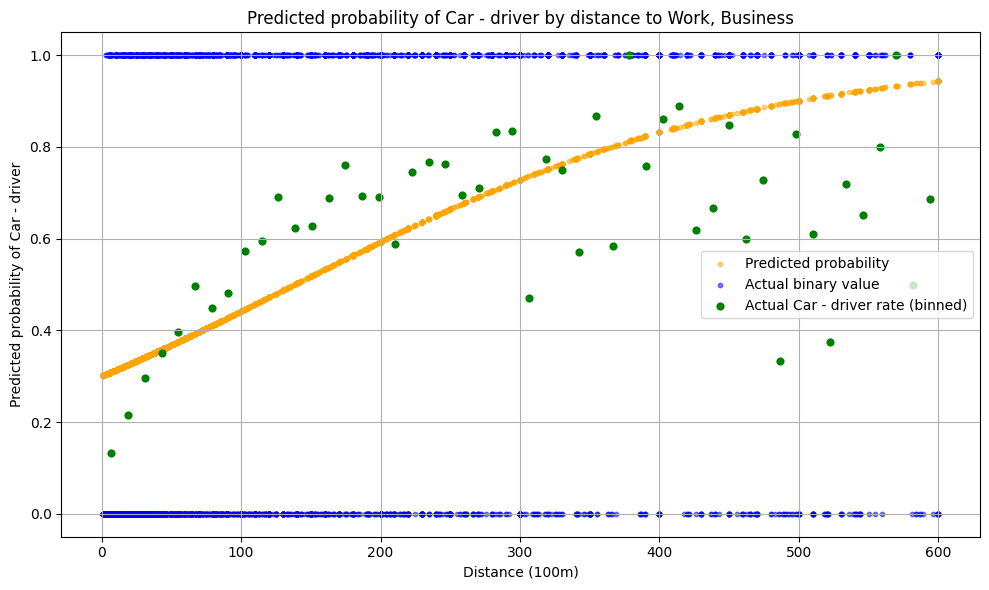

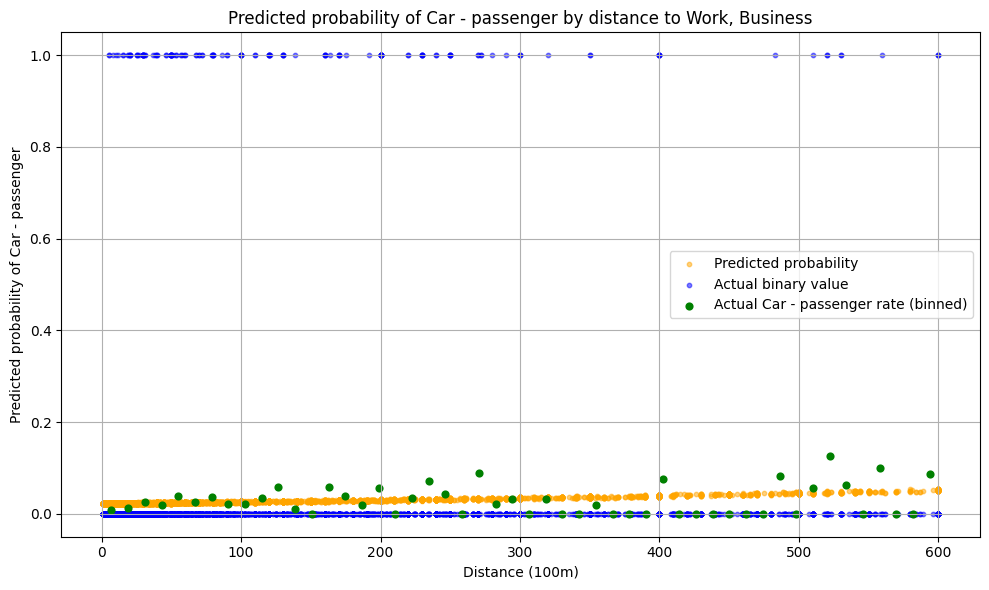

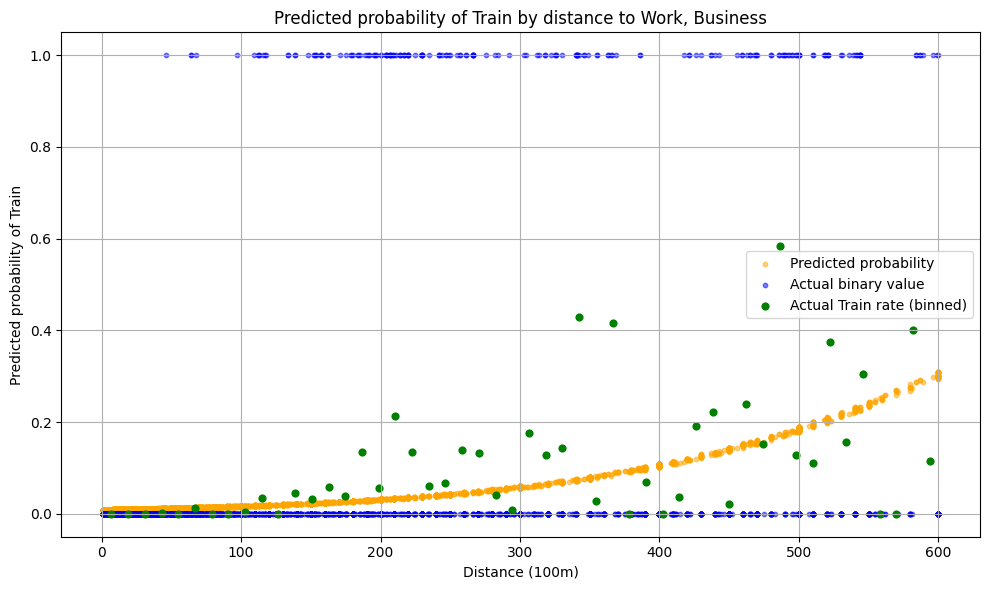

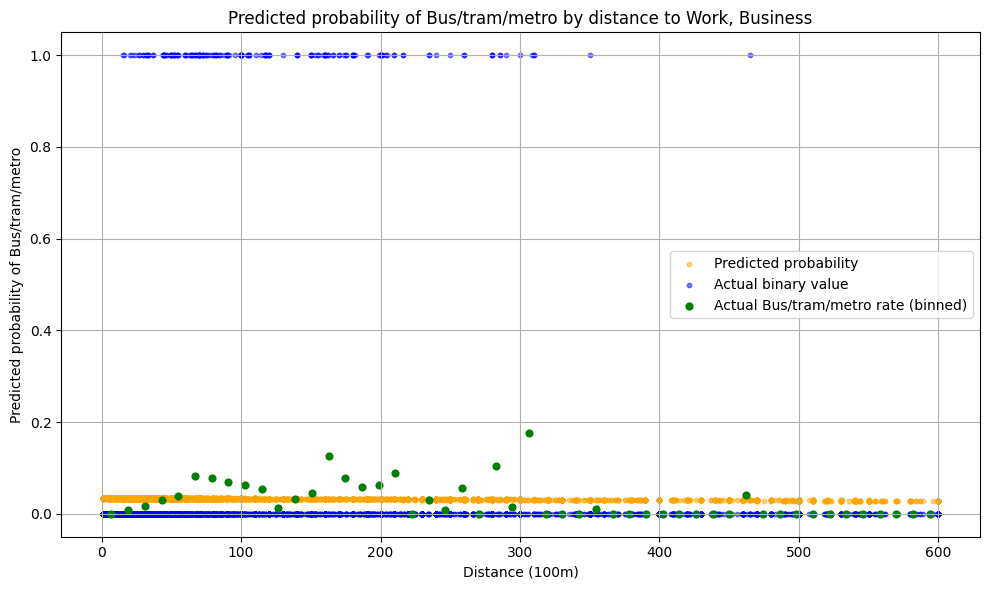

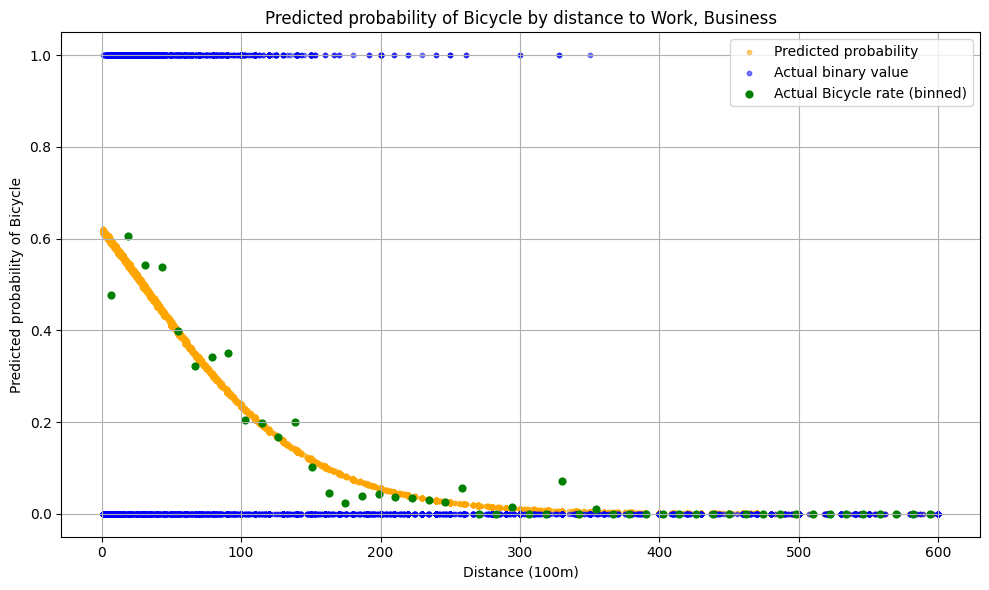

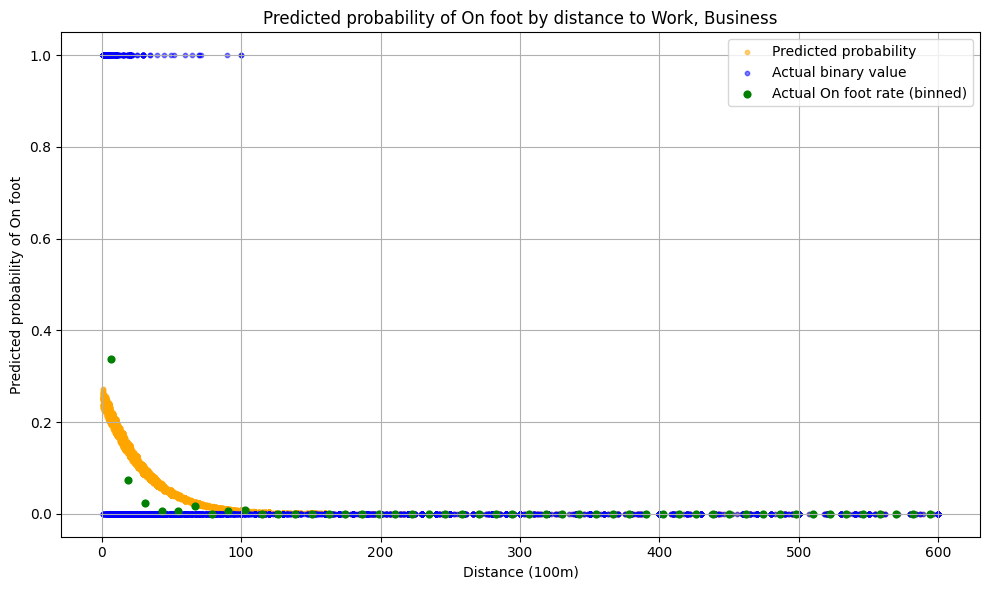

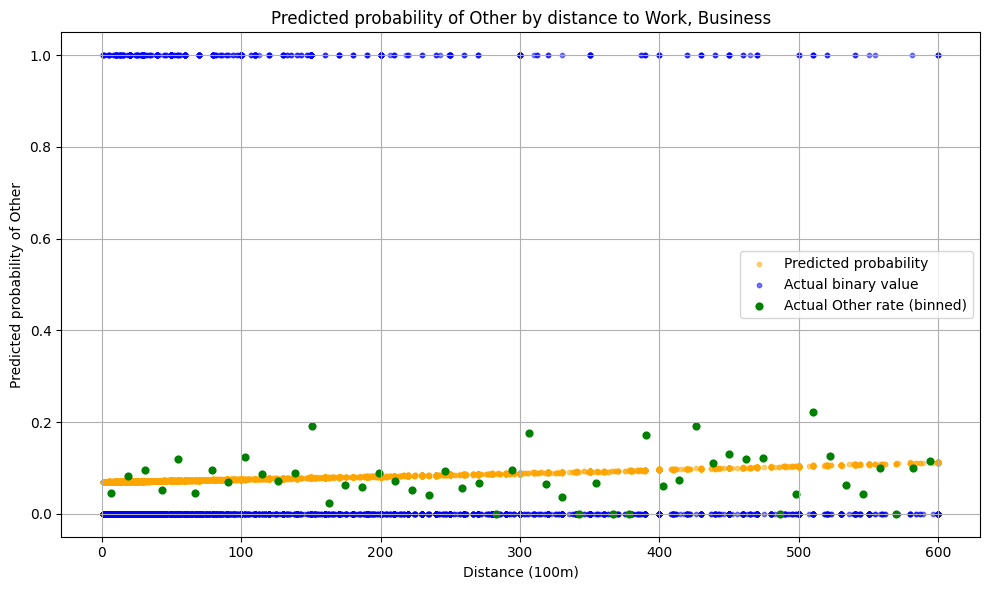

In [7]:
max_dist=600 # max distance in 100s of meters
motives=[1, 2] 

for transport_mode in transport_modes.keys():
    run_binary_regression(
        df,
        test_size=0.2,
        transport_mode=transport_mode,
        motives=motives,
        max_dist=max_dist,
        savename=f"graphics/classification_results/binary_regression/{motives}/{transport_modes[transport_mode].replace(r'/', ' or ')}_{max_dist}",
    )

Now a classifier that classifies what mode of transport was used

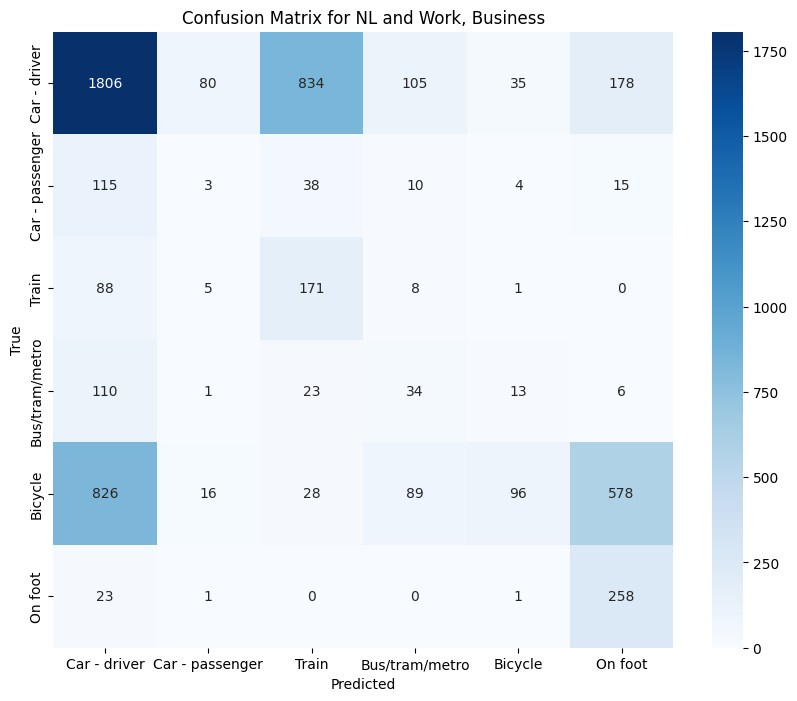

                 precision    recall  f1-score   support

   Car - driver       0.61      0.59      0.60      3038
Car - passenger       0.03      0.02      0.02       185
          Train       0.16      0.63      0.25       273
 Bus/tram/metro       0.14      0.18      0.16       187
        Bicycle       0.64      0.06      0.11      1633
        On foot       0.25      0.91      0.39       283

       accuracy                           0.42      5599
      macro avg       0.30      0.40      0.25      5599
   weighted avg       0.54      0.42      0.40      5599



(Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(class_weight='balanced', max_depth=10,
                                         n_jobs=-1, random_state=42))]),
 (                OPID  AfstV  VertPC_1011.0  VertPC_1012.0  VertPC_1013.0  \
  8       300000886980  170.0          False          False          False   
  9       300000886980  170.0          False          False          False   
  11      300000887980  380.0          False          False          False   
  12      300000887980  400.0          False          False          False   
  24      300001981980  540.0          False          False          False   
  ...              ...    ...            ...            ...            ...   
  199996  309998788880  370.0          False          False          False   
  200020  309999780980   90.0          False          False          False   
  200022  309999780980   90.0          False      

In [10]:
from codebase import run_multiclass_classification, distance_col, origin_col, province_codes, level_mapping_suffix, duration_col, transport_mode_col

df_multiclass = df[df[transport_mode_col] != df[transport_mode_col].max()]
motives=[1, 2]
origins=None#[7, 8, ]
location_level=2
categorical_features=[origin_col]
numerical_features=[distance_col]
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"
motive_str = ', '.join(trip_motives[motive] for motive in motives) if motives is not None else "all motives"

run_multiclass_classification(
    df_multiclass,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_features,
    numerical_features=numerical_features,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/{origins}/{motives}/{categorical_features + numerical_features}",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
)